In [1]:
import json
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from typing import List, Dict, Tuple, Callable
from sklearn.model_selection import train_test_split

### Class Training

In [2]:
class Training:

    """
    The class 'train_model', which inherits from the class 'Model', is initialized with a dictionary that contains some parameters for the training:

    - lr:         Learning rate (default = 0.001).
    - epochs:     Number of epochs to train (default = 100).
    - MAX_EPOCHS: Max number of epochs allowed (default = 1000).

    And contains six methods:

    - train
    - classify
    - evaluate_performance
    - split_data
    
    """

    def __init__(self, model, parameters_file: str):

        super().__init__()

        training_parameters = json.load(open(parameters_file))

        self.__model = model
        self.__training_dataloader = self.create_train_dataloader()
        # self.__preprocessor: [torch.nn.Module, None] = None
        self.__device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.lr = training_parameters['lr']
        self.epochs = training_parameters['epochs']
        self.MAX_EPOCHS = training_parameters['MAX_EPOCHS']


    def __call__(self, *args, **kwargs):
        
        return True

    @staticmethod
    def create_train_dataloader():
        mnist = fetch_openml('mnist_784', version=1, as_frame=False)
        X, Y = mnist["data"], mnist["target"]

        X_t = torch.from_numpy(X).float().cuda()
        Y_t = torch.from_numpy(Y.astype(int)).long().cuda()

        X_train, X_test, y_train, y_test = split_data(X_t, Y_t)
        return ((X_train, y_train))


    @staticmethod
    def cross_entropy(output, target):
        logits = output[torch.arange(len(output)), target]
        loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
        loss = loss.mean()
        return loss


    def train(self):
        """
        Method to train a model given a dataset.
        """

        self.__model.train()
        images, gts = self.__training_dataloader
        images.to(self.__device)
        gts.to(self.__device)

        # x = self._preprocess(x)

        epoch_loss = []
        epoch_batch = 10

        for epoch in range(1, self.epochs+1):  

            y_pred = self.__model(images)

            # Gradiends are turned to zero in order to avoid acumulation
            self.__model.zero_grad()

            # loss
            train_loss = self.cross_entropy(y_pred, gts)
            epoch_loss.append(train_loss.item())

            # Backprop
            train_loss.backward()

            # # updates
            with torch.no_grad():
                for param in self.__model.parameters():
                    param -= self.lr * param.grad

            # running_loss += train_loss.item()

            # # loss logger
            # self.log_metric("train_loss", train_loss)

            if not epoch % epoch_batch:
                print(f"Epoch {epoch}/{self.epochs} Loss {np.mean(epoch_loss):.5f}") 

            if epoch >= self.MAX_EPOCHS:
                break

        return True

    

### Test function split_data

In [3]:
def split_data(x_data, y_data, test_percent=0.20, seed=42):
        """
        The method split_data(), which belongs to the class Model, receives four parameters:

        - x_data: Samples (torch.Tensor).
        - y_data: Targets of the samples (torch.Tensor).
        - test_percent: Percentage of total data employed for testing (default = 0.20).
        - seed:         Used to replicate the resulting training and evaluation sets (default = None).

        And it is going to return two sets one for training and one for testing (each of which contains is divided into samples and targets).
        """

        x_numpy = x_data.cpu().numpy()
        y_numpy = y_data.cpu().numpy()

        X_train, X_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=test_percent, random_state=seed)
        
        return torch.from_numpy(X_train).float().cuda(), torch.from_numpy(X_test).float().cuda(), torch.from_numpy(y_train).long().cuda(), torch.from_numpy(y_test).long().cuda()

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, Y = mnist["data"], mnist["target"]

X_t = torch.from_numpy(X).float().cuda()
Y_t = torch.from_numpy(Y.astype(int)).long().cuda()

X_train, X_test, y_train, y_test = split_data(X_t, Y_t)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([56000, 784])
torch.Size([56000])
torch.Size([14000, 784])
torch.Size([14000])


Sample number: 6


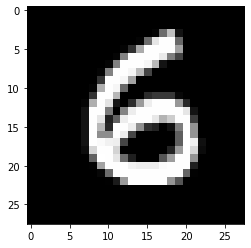

In [7]:
from matplotlib import pyplot as plt

num_sample = 120

print('Sample number: {}'.format(y_train[num_sample].cpu().numpy()))

plt.imshow(X_train[num_sample].reshape((28,28)).cpu().numpy(), cmap='gray')
plt.show()

### Test resizing images (3 channels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


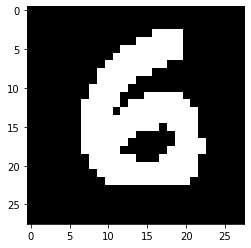

In [8]:
stacked_img = np.stack((X_train.cpu().numpy(),) * 3, axis=-1)
plt.imshow(stacked_img[num_sample].reshape((28,28,3)), cmap='gray')
plt.show()

### Test function get_accuracy

In [ ]:
def get_accuracy(model, x_data, y_data):
        """
        This method receives a set of samples (x_data), with their respective targets (y_data), and gets the accuracy of the model.
        """

        num_correct = 0
        num_samples = len(y_data)
        model.eval()
        
        with torch.no_grad():
            for x_sample, y_sample in zip(x_data, y_data):
                
                scores = model(x_sample)
                _, predictions = scores.max(1)
                num_correct += (predictions == y_sample).sum()
            
            return (num_correct/num_samples)*100
        

In [3]:
D_in, H, D_out = 784, 100, 10

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

model.to("cuda")

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

In [22]:
model(X_train[num_sample])

tensor([ 31.7624,   3.0775,  21.7556, -28.7571,   0.1901,  -5.1070,  13.5286,
          1.2703,  -3.5361,   9.5145], device='cuda:0', grad_fn=<AddBackward0>)

### Test parameters.json

In [47]:
new_training = Training(model, 'parameters.json')
new_training.epochs

100

### Test function pred

### Emulation __training_dataloader

In [103]:
from sklearn.datasets import fetch_openml

def __training_dataloader():
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, Y = mnist["data"], mnist["target"]

    X_t = torch.from_numpy(X).float().cuda()
    Y_t = torch.from_numpy(Y.astype(int)).long().cuda()

    X_train, X_test, y_train, y_test = split_data(X_t, Y_t)
    return ((X_train.shape, y_train.shape))

### Test funcion training

In [ ]:
def train(self):
    """
    Method to train a model given a dataset.
    """

    self.train()

    running_loss = 0.0
    for data in self.__training_dataloader:
        images, gts = data

        images.to(self.__device)
        gts.to(self.__device)

        # x = self._preprocess(x)

        # preds = self(images)

        # # ponemos a cero los gradientes
        # self.zero_grad()

        # # loss
        # train_loss = self.criterion(preds, gts)
        # train_loss.backward()

        # # updates
        # self.optimizer.step()

        # running_loss += train_loss.item()

        # # loss logger
        # self.log_metric("train_loss", train_loss)

    return (images.shape, gts.shape)

In [175]:
new_training = Training(model, 'parameters.json')
new_training.epochs

100

In [176]:
new_training.train()

Epoch 10/100 Loss 14.47456
Epoch 20/100 Loss 11.31852
Epoch 30/100 Loss 9.45172
Epoch 40/100 Loss 8.20859
Epoch 50/100 Loss 7.31508
Epoch 60/100 Loss 6.63780
Epoch 70/100 Loss 6.10433
Epoch 80/100 Loss 5.67161
Epoch 90/100 Loss 5.31241
Epoch 100/100 Loss 5.00867


True